In [1]:
import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import imageio
from skimage.transform import resize
import os
 
CHANNELS = ['red', 'green', 'blue', 'yellow']
TRAIN_CSV = 'D:/HPA_comp/single_cells/train.csv'
IMG_DIR = 'D:/HPA_comp/single_cells'

class CellDataset(object):
    '''Dataset class to fetch HPA cell-level images
    and corresponding weak labels
    '''
    def __init__(self, images, targets, img_root, augmentations=None):
        self.images = images
        self.targets = targets
        self.img_root = img_root
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_id = self.images[idx] 
        img_channels = self._fetch_channels(img_id)
        img = self._channels_2_array(img_channels)
        img = resize(img, (224, 224))  # Always resize cell images for collate function
        # If augmentation pipeline provided, apply augmentations
        if self.augmentations:
            img = self.augmentations(image=img)['image']
        # Adjust to channel first indexing for pytorch (speed reasons)
        features = np.transpose(img, (2, 0, 1)).astype(np.float32)
        target = self.targets[idx]  # Grab target vector
        
        return {'image': torch.tensor(features),
                'target': torch.tensor(target)
                }
    
    def _fetch_channels(self, img_id: str, channel_names=CHANNELS):
        'Return absolute path of segmentation channels of a given image id'
        base = os.path.join(self.img_root, img_id)
        return [base + '_' + i  + '.png' for i in channel_names]
                                         
    def _channels_2_array(self, img_channels):
        'Return 3D array of pixel values of input image channels'
        r = imageio.imread(img_channels[0])
        g = imageio.imread(img_channels[1])
        b = imageio.imread(img_channels[2])
        pixel_arr = np.dstack((r, g, b))
        return pixel_arr

In [2]:
def gen_dataloader(df, img_dir, bs, shuffle, aug=None):
        'Return pytorch dataloader generated from cell image dataframe'
        # Extract images and targets as numpy arrays from dataframe tranche
        def extract_as_array(str_):
            list_ = str_.strip('][').split(', ')
            return np.array([int(i) for i in list_])
        images = df['cell_id'].values
        targets = df['Label'].apply(extract_as_array).values
        # Init custom dataset class and pass to pytorch
        dataset = CellDataset(images, targets, img_dir, aug)
        return DataLoader(dataset, batch_size=bs, shuffle=shuffle)

In [3]:
def grab_pixel_aggs(dataloader, sample_size):
    'Return dataframe of image channel means and standard deviations'
    aggs_df = pd.DataFrame()
    
    for count, sample in enumerate(dataloader):
        image_tensor = sample['image']  # indexed by (C, H, W)
        aggs = {}
        # Grab cell image channel aggregates
        channels = ['red', 'green', 'blue']
        for idx, channel_name in enumerate(channels):
            channel = image_tensor[0, idx, :, :]
            min_value = channel.min().item()
            max_value = channel.max().item()
            mean = channel.mean().item()
            std = channel.std().item()
            aggs[channel_name + '_max'] = max_value
            aggs[channel_name + '_min'] = min_value
            aggs[channel_name + '_mean'] = mean
            aggs[channel_name + '_std'] = std
        aggs_df = aggs_df.append(aggs, ignore_index=True)
        if count >= sample_size:
            break
    return aggs_df

In [4]:
df = pd.read_csv(TRAIN_CSV, index_col=0)
loader = gen_dataloader(df, img_dir=IMG_DIR, bs=1, shuffle=True, aug=None)
aggs_df = grab_pixel_aggs(loader, sample_size=1000)
aggs_df.head()

,blue_max,blue_mean,blue_min,blue_std,green_max,green_mean,green_min,green_std,red_max,red_mean,red_min,red_std
0,0.575451,0.058400,0.0,0.122488,1.000000,0.115042,0.0,0.148649,0.962443,0.045110,0.0,0.083700
1,0.678051,0.071728,0.0,0.158510,0.996078,0.144842,0.0,0.205840,0.996078,0.080054,0.0,0.161126
2,0.683785,0.071366,0.0,0.133377,0.987560,0.022649,0.0,0.055525,0.988698,0.052086,0.0,0.101853
3,0.738046,0.055801,0.0,0.150641,0.940102,0.033096,0.0,0.086506,0.996078,0.061397,0.0,0.148538
4,0.578725,0.036302,0.0,0.097285,0.774214,0.035447,0.0,0.079307,0.617501,0.018010,0.0,0.049959


In [7]:
aggs_df.shape

(1001, 12)

### Print magic numbers

In [5]:
print(f'Red channel mean:   {aggs_df.red_mean.mean()}')
print(f'Red std dev:   {aggs_df.red_std.mean()}')
print(f'Blue channel mean:   {aggs_df.blue_mean.mean()}')
print(f'Blue std dev:   {aggs_df.blue_std.mean()}')
print(f'Green channel mean:   {aggs_df.green_mean.mean()}')
print(f'Green std dev:   {aggs_df.green_std.mean()}')
print('Global max:   1')

Red channel mean:   0.0773003577244769
Red std dev:   0.12031813858395124
Blue channel mean:   0.07135171427789073
Blue std dev:   0.14364256429018804
Green channel mean:   0.05958716537871795
Green std dev:   0.08592740841582976
Global max:   1


In [6]:
aggs_df.max()

blue_max      1.000000
blue_mean     0.507391
blue_min      0.000000
blue_std      0.464295
green_max     1.000000
green_mean    0.597693
green_min     0.000000
green_std     0.448482
red_max       1.000000
red_mean      0.273669
red_min       0.000000
red_std       0.342685
dtype: float64

-
-
-
-
-
-
-
-
-
-

Notepad:

In [ ]:
for i in loader:
    img = i['image']
    break

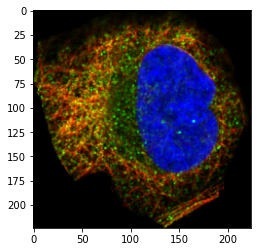

In [35]:
import matplotlib.pyplot as plt
array_img = np.array(img)[0, :, :, :]
array_img = np.transpose(array_img, (1, 2, 0))
plt.imshow(array_img)